In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090b_hw2.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 2: Artificial Neural Networks, Model Interpretation, and Regularization


**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb

<hr style="height:2pt">

In [2]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [13]:
import random
random.seed(109)

import os
import sys
import time
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.calibration import LabelEncoder

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.utils import plot_model
from tensorflow import keras

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("Memory growth enabled on all GPUs")

Memory growth enabled on all GPUs


In [5]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [6]:
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Test with a simple operation
with tf.device('/device:GPU:0'):
    a = tf.random.normal([1000, 1000])
    b = tf.random.normal([1000, 1000])
    c = tf.matmul(a, b)
    print("Operation successful on GPU")


TensorFlow version: 2.16.2
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Operation successful on GPU


2025-03-05 22:40:00.408368: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-03-05 22:40:00.408395: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2025-03-05 22:40:00.408400: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
2025-03-05 22:40:00.408416: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-05 22:40:00.408427: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# measure notebook runtime
time_start = time.time()

<div style = "background: lightsalmon; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should includelabels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>

<a id="contents"></a>

# Notebook Contents

- [**PART 1 [50 pts]: Modeling and predictive intervals in ANNs**](#part1)
  - [Overview and Data Description](#part1intro)
  - [Questions](#part1questions)


- [**PART 2 [50 pts]: 'Quick, Draw!' Kaggle competition**](#part2)
  - [Problem Statement](#part2intro)
  - [The "Quick, Draw!" Dataset](#part2about)
  - [Downloading the Data Files](#part2data)
  - [CS1090B Kaggle Competition](#part2kaggle)
  - [Questions](#part2questions)


<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 1 [50 pts]: Model interpretation and predictive intervals in ANNs

[Return to contents](#contents)

<a id="part1intro"></a>

## Overview and Data Description

[Return to contents](#contents)

In this problem, you will be building and interpreting models to predict whether a flight was delayed for its arrival. The model will be based on features that can be measured as the flight takes off.

We will also estimate the predictive intervals of the model using bootstrapping. We will utilize those predictive intervals to build a new kind of model: a model that refrains from making a prediction when it is not confident.

The variable in the original csv are:

    
**ARRIVAL_DELAY**: the difference between scheduled arrival and actual arrival, in minutes (positive is late, negative is early).

**DISTANCE**: the distance between arrival and departure airports, in miles.

**SCHEDULED_TIME**: the flight's scheduled travel time in minutes.

**MONTH**: the month the flight took off, 1 = January, 2 = February, etc.

**SCHED_DEP_HOUR**: the scheduled departure time (the hour of the day).

**SCHED_ARR_HOUR**: the scheduled arrival time (the hour of the day).

**FLIGHT_COUNT**: the number of flights flying out of the origin airport before noon on a typical day.

**DAY_OF_WEEK**: the day of the week, 1 = Monday, 2 = Tuesday, etc.

**ORIGIN_AIRPORT**: the airport the flight took off from.

**DESTINATION_AIRPORT**: the airport the flight was scheduled to land at.

For the airport codes, see: https://www.bts.gov/topics/airlines-and-airports/world-airport-codes

To sucessfully complete this part, you will proceed by fitting a NN model, evaluating its accuracy, interpreting the predictors' importance, and finally evaluating the predictive intervals.

**NOTE:** the observations were sampled so that roughly half of the observations were delayed and half of the observations were not delayed.

<!-- </div> -->

<a id="part1solutions"></a>

## PART 1 Questions

[Return to contents](#contents)


<div class='exercise-r'>

**1.1**  **Preprocess the data**

**Note that this part (section 1.1) has been completed for you. Simply run the provided cells below to load and preprocess the data. While you do not need to write any code here, you are expected to read through the processing steps taken here so that you fully understand the data you'll be working with.**


</div>

<div class='exercise-r'>

**1.1.1**   Read in the dataset `data/flights.csv` into a DataFrame called `df_flights`. Create a new column in the DataFrame called `DELAY_OR_NOT`. This is a binary variable that denotes whether `ARRIVAL_DELAY` is greater-than-or-equal-to 15 minutes (the FAA and BTS define a flight as delayed by 15 minutes or more). This is going to be the response variable for the rest of part 1. 




</div>

In [8]:
df_flights = pd.read_csv("data/flights.csv")
df_flights.info()
df_flights.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ARRIVAL_DELAY        10000 non-null  int64  
 1   DISTANCE             9995 non-null   float64
 2   SCHEDULED_TIME       9999 non-null   float64
 3   MONTH                10000 non-null  int64  
 4   SCHED_DEP_HOUR       10000 non-null  int64  
 5   SCHED_ARR_HOUR       10000 non-null  int64  
 6   FLIGHT_COUNT         9995 non-null   float64
 7   DAY_OF_WEEK          10000 non-null  int64  
 8   ORIGIN_AIRPORT       10000 non-null  object 
 9   DESTINATION_AIRPORT  10000 non-null  object 
dtypes: float64(3), int64(5), object(2)
memory usage: 781.4+ KB


,ARRIVAL_DELAY,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT
0,23,2586.0,342.0,9,7,15,240.0,3,SFO,JFK
1,10,1235.0,185.0,5,6,11,366.0,4,LAX,DFW
2,-7,184.0,76.0,4,17,18,172.0,7,BOS,LGA
3,68,862.0,148.0,7,19,21,260.0,7,IAH,DEN
4,24,236.0,71.0,3,20,21,266.0,2,LAS,LAX


In [9]:
df_flights["DELAY_OR_NOT"] = (df_flights["ARRIVAL_DELAY"] >= 15).astype(int)

delay_counts = df_flights["DELAY_OR_NOT"].value_counts().sort_index()

print(
    "The resulting counts for our \"DELAY_OR_NOT\" response variable,\n"
    "where class 1 are flights with actual arrivals 15 minutes late\n"
    "or later than scheduled, are:\n\n\tclass\tobservations"
)
for resp, value in zip(delay_counts.index, delay_counts.values):
    print("\t{}  \t{:,.0f}".format(resp, value))

The resulting counts for our "DELAY_OR_NOT" response variable,
where class 1 are flights with actual arrivals 15 minutes late
or later than scheduled, are:

	class	observations
	0  	5,069
	1  	4,931


<div class='exercise-r'>

**1.1.2 Preprocess the data**
    
- Deal with missing values if there are any
- One-hot-encode the non-numeric categorical variables
- Split the data using an 80/20 train-test split with `random_state=109` and stratifying on the response variable
- Standardize train and test with the scaler fit on the train data

Print the resulting shapes of your $X$ and $y$ dataframes for both your train and your test sets.
    
**NOTE:** While inspecting your data, you may notice that a large number of airport codes are recorded using 5-digit values instead of the expected 3-letter codes. That is perfectly fine. Those 5-digit values should be considered valid and just be treated the same as they would be if they were 3-letter codes.

**TIPS:** 
- month and day-of-the-week should be treated as numerical in this context.
- you should consider what predctors are acceptable to include given our goal is to predict if a flight is delayed.


</div>

In [10]:
# By displaying rows with missing values, we can see
# that ALL missing values occur for flights between
# BOS and SFO. This would indicate that these values are NOT
# missing at random. Therefore, we will want to impute our
# values rather than simply delete these rows
print("ALL MISSING VALUE ROWS, THEY APPEAR TO BE BSO TO SFO FLIGHTS:")
display(df_flights[df_flights.isnull().any(axis=1)])

# The next thing we will do is display all BOS to SFO observations
# to determine how we should treat missing values in each
# predictor column.
print(
    "\nALL BOS TO SFO FLIGHT OBSERVATIONS (INCLD. THOSE WITH MISSINGNESS):"
)
loc_filter = (df_flights["ORIGIN_AIRPORT"] == "BOS") & (df_flights["DESTINATION_AIRPORT"] == "SFO")
display(df_flights.loc[loc_filter])

# We can see that we know the exact values to enter for missing
# DISTANCE and missing FLIGHT_COUNT values, so rather than
# impute, we can just explicilty set the values as such, being
# certain to fix the column dtypes as well
df_flights["DISTANCE"] = df_flights["DISTANCE"].fillna(2704).astype(int)
df_flights["FLIGHT_COUNT"] = df_flights["FLIGHT_COUNT"].fillna(172).astype(int)

# As for the one missing SCHEDULED_TIME value, we could do
# something more involved like creating some sort of imputation model
# (such as trying to predict that one value using kNN), but because it's only
# one value and there does not appear to be much variability in time among
# the flights between BOS and SFO, we can probably just get away with populating
# this cell with the mean SCHEDULED_TIME for all flights between BOS and SFO
mean_time = df_flights.loc[loc_filter]["SCHEDULED_TIME"].mean()
df_flights["SCHEDULED_TIME"] = df_flights["SCHEDULED_TIME"].fillna(mean_time).astype(int)

# To wrap up, we'll print the df_flights info again to confirm no more
# missing values exist
print("\nTHE df_flights DATAFRAME AFTER RESOLVING MISSINGNESS:\n")
display(df_flights.info())

ALL MISSING VALUE ROWS, THEY APPEAR TO BE BSO TO SFO FLIGHTS:


,ARRIVAL_DELAY,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DELAY_OR_NOT
70,13,NaN,395.0,11,6,9,NaN,1,BOS,SFO,0
1566,-4,NaN,418.0,2,6,9,NaN,5,BOS,SFO,0
3741,-33,NaN,419.0,11,11,15,NaN,2,BOS,SFO,0
5612,-9,NaN,381.0,6,8,12,NaN,5,BOS,SFO,0
6375,17,NaN,NaN,7,18,21,NaN,3,BOS,SFO,1



ALL BOS TO SFO FLIGHT OBSERVATIONS (INCLD. THOSE WITH MISSINGNESS):


,ARRIVAL_DELAY,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DELAY_OR_NOT
70,13,NaN,395.0,11,6,9,NaN,1,BOS,SFO,0
155,-17,2704.0,390.0,8,7,10,172.0,6,BOS,SFO,0
1566,-4,NaN,418.0,2,6,9,NaN,5,BOS,SFO,0
1729,16,2704.0,390.0,9,20,23,172.0,1,BOS,SFO,1
2775,-9,2704.0,403.0,3,11,14,172.0,1,BOS,SFO,0
3132,101,2704.0,412.0,2,16,20,172.0,4,BOS,SFO,1
3741,-33,NaN,419.0,11,11,15,NaN,2,BOS,SFO,0
5612,-9,NaN,381.0,6,8,12,NaN,5,BOS,SFO,0
5929,-5,2704.0,404.0,3,6,9,172.0,1,BOS,SFO,0
6375,17,NaN,NaN,7,18,21,NaN,3,BOS,SFO,1



THE df_flights DATAFRAME AFTER RESOLVING MISSINGNESS:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ARRIVAL_DELAY        10000 non-null  int64 
 1   DISTANCE             10000 non-null  int64 
 2   SCHEDULED_TIME       10000 non-null  int64 
 3   MONTH                10000 non-null  int64 
 4   SCHED_DEP_HOUR       10000 non-null  int64 
 5   SCHED_ARR_HOUR       10000 non-null  int64 
 6   FLIGHT_COUNT         10000 non-null  int64 
 7   DAY_OF_WEEK          10000 non-null  int64 
 8   ORIGIN_AIRPORT       10000 non-null  object
 9   DESTINATION_AIRPORT  10000 non-null  object
 10  DELAY_OR_NOT         10000 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 859.5+ KB


None

In [11]:
# identify our response variable
response = "DELAY_OR_NOT"

# identify categorical predictors for one-hot-encoding
cat_preds = ["ORIGIN_AIRPORT", "DESTINATION_AIRPORT"]

# identify columns we will need to drop from X after encoding 
drop_cols = ["ARRIVAL_DELAY", response] + cat_preds

# one-hot-encode and make certain to drop one col for each predictor
df_one_hot = pd.get_dummies(df_flights[cat_preds], drop_first=True)

# merge encoded columns with other predictor columns to create
# our X data, being certain to drop non-predictor columns
X_flights = pd.concat(
    [
        df_flights.drop(columns=drop_cols),
        df_one_hot,
    ],
    axis=1,
)
y_flights = df_flights[response]

X_train, X_test, y_train, y_test = train_test_split(
    X_flights, y_flights, test_size=0.20, random_state=111, stratify=y_flights
)

# scale X data using standard scaler, and retain our original
# X dataframes so we can use them to plot data in its
# original scale for Q1.4 later in HW3
X_train_std = X_train.copy()
X_test_std = X_test.copy()

scaler = StandardScaler().fit(X_train)
X_train_std[X_train.columns] = scaler.transform(X_train)
X_test_std[X_test.columns] = scaler.transform(X_test)

# print our resulting X and y shapes
print(
    "The shapes of our resulting X and y train and test sets are:\n\n"
    "\tX_train\t{}\n\ty_train\t{}\n\n\tX_test\t{}\n\ty_test\t{}\n"
    .format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape,
    )
)

The shapes of our resulting X and y train and test sets are:

	X_train	(8000, 808)
	y_train	(8000,)

	X_test	(2000, 808)
	y_test	(2000,)



<div class='exercise-r'>

**1.2**  **Fit an ANN**

Fit an artificial neural network model using all predictors (name this model `NN_model`).  Use a dense feed-forward network with two hidden layers with 15 nodes in each hidden layer. For this network, use a reasonable activation functions for the hidden layers and output, select an appropriate loss function and optimizer, specify a validation split of 0.2, and train for a reasonable number of epochs and batch size of your choice. Plot the training accuracy and validation accuracy as a function of epochs from your `NN_model`'s training history. Evaluate the `NN_model` model on both train and test, and print out the resulting train and test accuracies.

You should base your choice of "a reasonable number of epochs" on a visualization of the model's training history.

<a id="q12"></a>



</div>

In [12]:
# build your NN 
# your code here
tf.random.set_seed(111)

# Build NN with 2 hidden layers of 15 nodes each
# ReLU activation function for hidden layers
# Sigmoid activation function for output layer
NN_model = Sequential([
    Dense(15, activation="relu", kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(15, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1, activation="sigmoid"),
])

# Display model summary
NN_model.summary()

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 15)             │        12,135 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,391 (48.40 KB)

 Trainable params: 12,391 (48.40 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# compile it and run it
# your code here 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

NN_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Train model with val split
history = NN_model.fit(
    X_train_std,
    y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1,
)

Epoch 1/100


2025-03-05 18:43:07.415484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-03-05 18:43:07.417253: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5031 - loss: 0.8560 - val_accuracy: 0.4762 - val_loss: 0.8141
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5201 - loss: 0.8462 - val_accuracy: 0.4762 - val_loss: 0.7994
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5162 - loss: 0.8264 - val_accuracy: 0.4881 - val_loss: 0.7863
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5187 - loss: 0.8197 - val_accuracy: 0.4963 - val_loss: 0.7765
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5327 - loss: 0.7910 - val_accuracy: 0.5156 - val_loss: 0.7681
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5292 - loss: 0.7814 - val_accuracy: 0.5294 - val_loss: 0.7607
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5435 - loss: 0.7683 - val_accuracy: 0.5387 - val_loss: 0.7541
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5626 - loss: 0.7547 - val_accuracy: 0.5425 - val_l

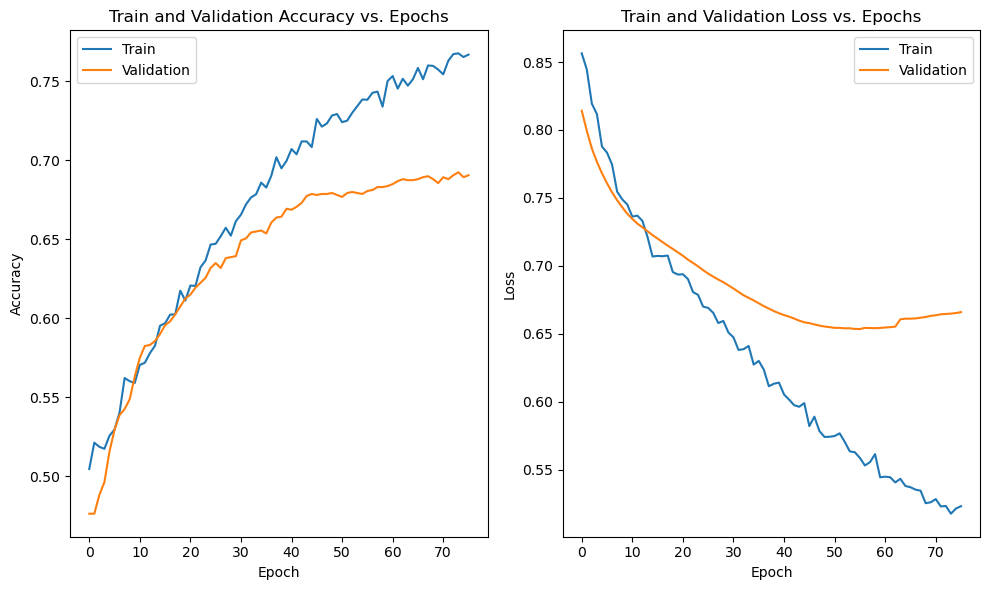

Training stopped at epoch 76


In [14]:
# plot train and val acc as a function of epochs
# your code here
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy vs. Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Print epoch where early stopping occurred
print(f"Training stopped at epoch {len(history.history['loss'])}")

In [15]:
# evaluate on train and test and print accuracy results
# your code here 
# Evaluate model on train data
train_loss, train_accuracy = NN_model.evaluate(X_train_std, y_train, verbose=0)
print(f"Train Accuracy: {train_accuracy:.4f}")

# Evaluate model on test data
test_loss, test_accuracy = NN_model.evaluate(X_test_std, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print difference
print(f"Difference (Train Accuracy - Test Accuracy): {train_accuracy - test_accuracy:.4f}")

Train Accuracy: 0.7585
Test Accuracy: 0.6840
Difference (Train Accuracy - Test Accuracy): 0.0745


<div class='exercise-r'>

**1.3**  **Bootstrap prediction intervals**

In HW1, we saw how we could use MCMC to perform Bayesian inference on the parameters of a logistic regression model. This gave us access not only to samples from the posterior distribution (betas) but we could also generate samples from the posterior predictive distribution (data). The posterior predictive can be used to represent our uncertainy about a given prediction, $\hat{y}$.

We'd like to do something similar for our neural network here so that we can quantify the uncertainty in our predictions. But there are some problems. First, we haven't (explicitly) specified any priors on the network weights. Second, and more serious, neural networks have many, many parameters. Far too many for MCMC to be a viable approach. Sampling in such a high dimensional space is simply intractable.

Bootstrap to the rescue!

Using the same network architecture as `NN_model` (layers, nodes, activations, etc.) and your scaled data from that model, create multiple training sets using bootstrapping and fit a separate neural network model to each bootstrapped set of data (the number of bootstraped *datasets*, $n$, should be at least 50). For each of the $n$ models, make predictions on the test data. Randomly select 8 test observations and on 8 subplots, plot the distribution of the $n$ predicted probabilities with the 95% prediction intervals clearly marked and reported in each subplot and the **actual** class of each observation included in each subplot's title for easy reference.
    
Interpret what you see in 3-5 sentences.

**NOTE:** The code for this problem can take an extremely long time to execute. Please feel free to use the `progressbar` function provided below to visually track the progress of your bootstraps.

<a id="q13"></a>


</div>

In [16]:
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress
    
    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.
    
    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::
    
        for i in range(n_iterations):
            progressbar(i, n_iterations)
            
    .. source:
    
        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

In [17]:
%%time
# Bootstrap and train your networks and get predictions on X test
# your code here
# Set random seeds
np.random.seed(111)
tf.random.set_seed(111)

# Number of bootstraps
n_bootstraps = 50

# Store predictions for each bootstrap model
bootstrap_preds = np.zeros((len(X_test_std), n_bootstraps))

# Function to create NN with same architecture as before
def create_NN():
    model = Sequential([
        Dense(15, activation="relu", kernel_regularizer=l2(0.001), input_shape=(X_train_std.shape[1],)),
        Dropout(0.3),
        Dense(15, activation="relu", kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(1, activation="sigmoid"),
    ])
    
    optimizer = Adam(learning_rate=0.0002)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )
    return model

# Train with bootstrap samples
for i in range(n_bootstraps):
    progressbar(i, n_bootstraps)

    # Create bootstrap sample
    bootstrap_indices = np.random.choice(len(X_train_std), size=len(X_train_std), replace=True)
    X_boot = X_train_std.iloc[bootstrap_indices]
    y_boot = y_train.iloc[bootstrap_indices]

    # Create and train model
    bootstrap_model = create_NN()

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Train model with smaller number of epochs
    bootstrap_model.fit(
        X_boot,
        y_boot,
        epochs=30,
        batch_size=256,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0,
    )

    # Make predictions with eager execution enabled
    preds = bootstrap_model.predict(X_test_std, verbose=0).flatten()
    bootstrap_preds[:, i] = preds

 [=-------------------------------------------------] 1/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [==------------------------------------------------] 2/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [===-----------------------------------------------] 3/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [====----------------------------------------------] 4/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [=====---------------------------------------------] 5/50 

2025-03-05 18:44:08.826428: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [======--------------------------------------------] 6/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [=======-------------------------------------------] 7/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [========------------------------------------------] 8/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [=========-----------------------------------------] 9/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [==========----------------------------------------] 10/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [===========---------------------------------------] 11/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [============--------------------------------------] 12/50 

2025-03-05 18:45:14.267405: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [=============-------------------------------------] 13/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [==============------------------------------------] 14/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [===============-----------------------------------] 15/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [================----------------------------------] 16/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [=================---------------------------------] 17/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [==================--------------------------------] 18/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [===================-------------------------------] 19/50 

2025-03-05 18:46:19.547895: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [====================------------------------------] 20/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [=====================-----------------------------] 21/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [======================----------------------------] 22/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [=======================---------------------------] 23/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [========================--------------------------] 24/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [=========================-------------------------] 25/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [==========================------------------------] 26/50 

2025-03-05 18:47:25.645254: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [===========================-----------------------] 27/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [============================----------------------] 28/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [=============================---------------------] 29/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [==============================--------------------] 30/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [===============================-------------------] 31/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [================================------------------] 32/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [=================================-----------------] 33/50 

2025-03-05 18:48:31.695415: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [==================================----------------] 34/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [===================================---------------] 35/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [====================================--------------] 36/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [=====================================-------------] 37/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [======================================------------] 38/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [=======================================-----------] 39/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [========================================----------] 40/50 

2025-03-05 18:49:37.438761: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [=========================================---------] 41/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [==========================================--------] 42/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [===========================================-------] 43/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [============================================------] 44/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [=============================================-----] 45/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [==============================================----] 46/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [===============================================---] 47/50 

2025-03-05 18:50:42.680095: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [================================================--] 48/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [=================================================-] 49/50 

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 [==================================================] 50/50 Done...



/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CPU times: user 7min 49s, sys: 5min 48s, total: 13min 37s
Wall time: 7min 47s


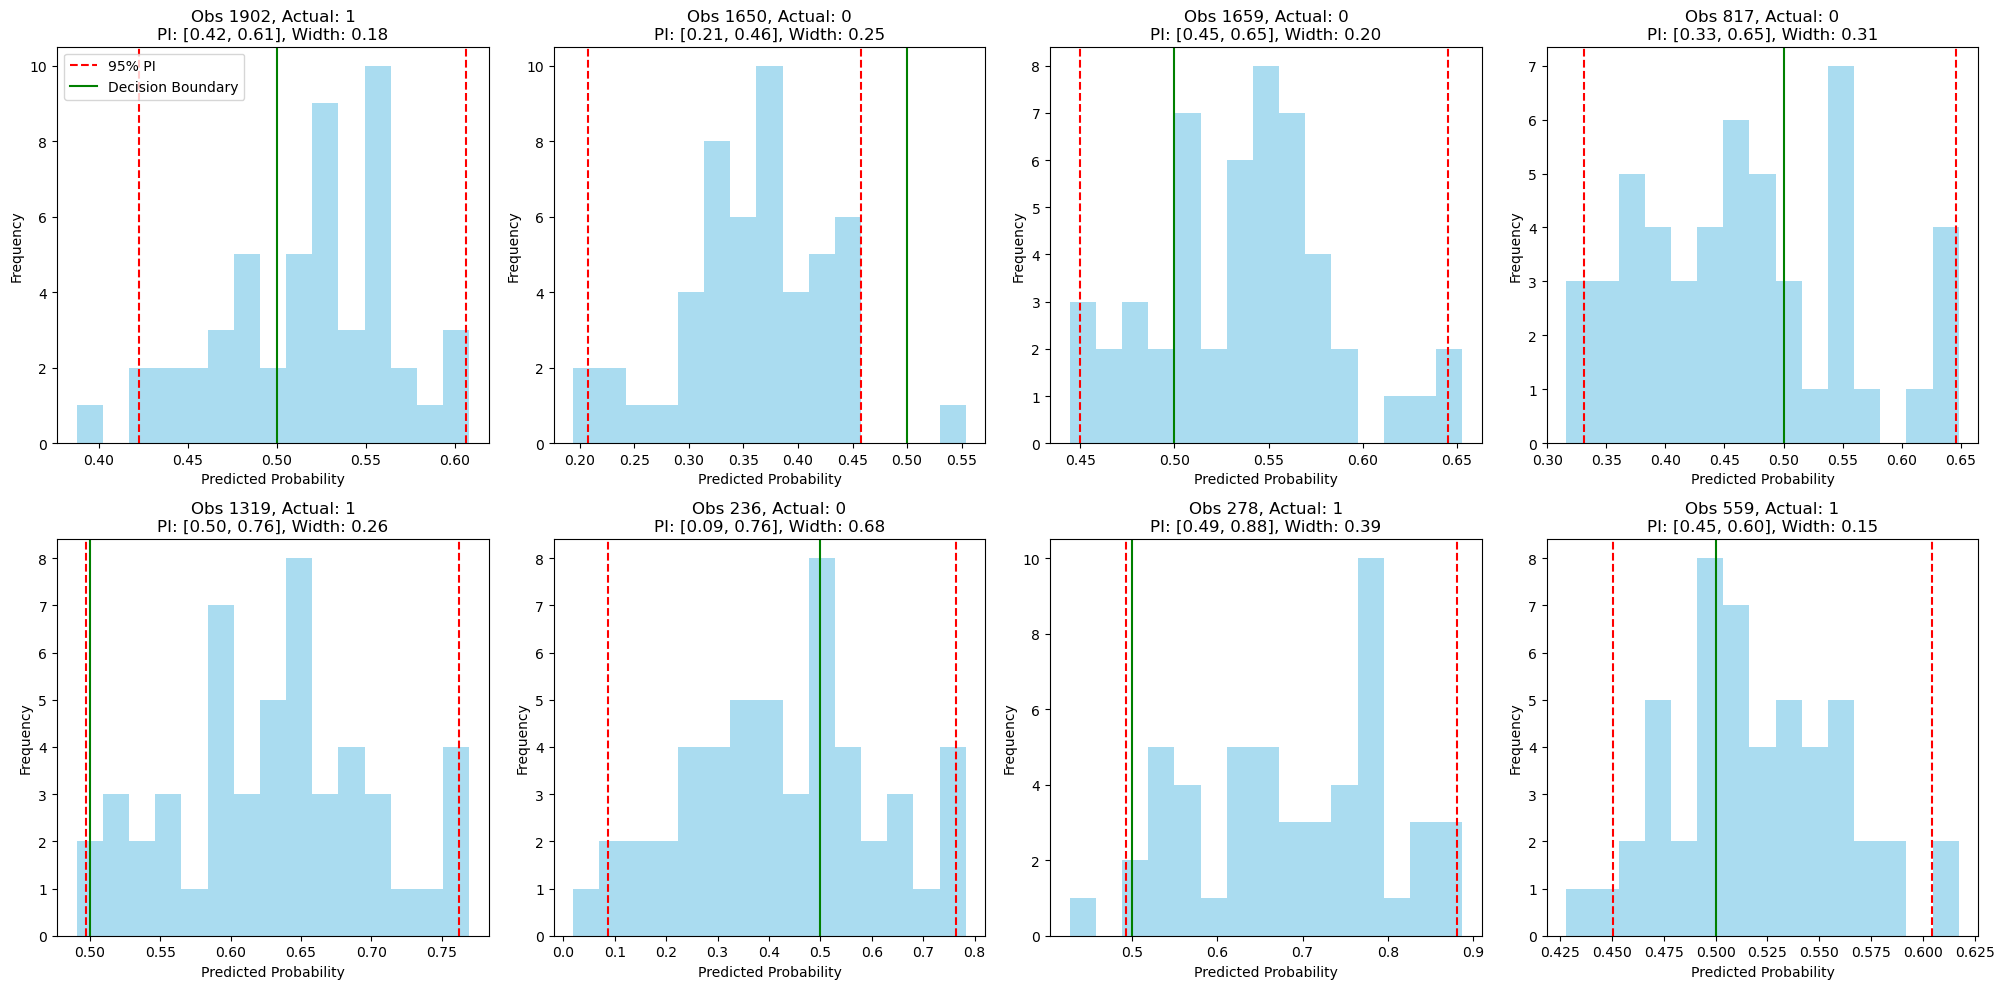

In [22]:
# generate your plot
# your code here
# Randomly select 8 test observations
np.random.seed(111)
random_indices = np.random.choice(len(X_test_std), size=8, replace=False)

# Calculate 95% prediction intervals
lower_bounds = np.percentile(bootstrap_preds, 2.5, axis=1)
upper_bounds = np.percentile(bootstrap_preds, 97.5, axis=1)

# Create plots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    # Get actual class
    actual_class = y_test.iloc[idx]
    
    # Plot histogram of predictions
    axes[i].hist(bootstrap_preds[idx], bins=15, alpha=0.7, color='skyblue')
    
    # Add vertical lines for 95% prediction interval
    axes[i].axvline(lower_bounds[idx], color='red', linestyle='--', label='95% PI')
    axes[i].axvline(upper_bounds[idx], color='red', linestyle='--')
    
    # Add decision boundary line at 0.5
    axes[i].axvline(0.5, color='green', linestyle='-', label='Decision Boundary')
    
    # Add title with actual class and prediction interval
    interval_width = upper_bounds[idx] - lower_bounds[idx]
    axes[i].set_title(f"Obs {idx}, Actual: {actual_class}\nPI: [{lower_bounds[idx]:.2f}, {upper_bounds[idx]:.2f}], Width: {interval_width:.2f}")
    
    axes[i].set_xlabel("Predicted Probability")
    axes[i].set_ylabel("Frequency")
    
    if i == 0:
        axes[i].legend()

plt.tight_layout()
plt.show()

*The bootstrap prediction intervals reveal varying level of model vertainty across different observations. Some cases show strong consensus among models, like Observations 278, 1319, and 1650 as a large portion of the predicted probabilities lie on the same side of the decision boundary, and in these specific cases, the correct side of the decision boundaries. However, other observations such as Observations 236, 817, and 1902 show wide prediction intervals with more equal distribution of predicted probabilities above and below the decision boundaries, indicating signs of uncertainty. This uncertainty visualization overall demonstrates that the neural network doesn't just make binary predictions but has varying degrees of confidence which could be leveraged to improve decision-making, potentially by withholding predictions when uncertainty is too high for example.*


<div class='exercise-r'>

**1.4**  **Build an "abstain" bagging model**

Using the probability distribution of the predictions obtained from the bootstrapped samples above, we can evaluate how confident we should be in our bagged (i.e. bootstrap-aggregated) predictions for each test observation.

To accomplish this, you will first calculate a metric we'll call the **Posterior Prediction Dissent (PPD)** related to the proportion of predictions a given test observation receives for the minority opinion. Some examples: if 10% of the bootstrapped models predict $\hat{y} = 0$ with the remaining 90% predicting $\hat{y}=1$, then the $PPD=0.1$. When a bagged prediction's $PPD=0$, all predictions are compatible (i.e. all bootstrapped probabilities for that test observation are on the same side of $\hat{p}=0.5$). Likewise, when the $PPD=0.5$, half of the bootstrapped predictions for that test observation are $\hat{y}=0$, and the other half are $\hat{y}=1$. After calculating your $PPD$ values for all test observations, you should have $n=2000$ $PPD$ values (i.e. one for each test observation).

Next, to get more accurate predictions, we can create an **abstain** model that will abstain from making a prediction for a particular observation if some defined threshold for lack-of-confidence (i.e. maximum permissible $PPD$ value) is crossed. (If you'd like to learn more about abstain models, you can read more [here](https://openreview.net/forum?id=rJxF73R9tX).)

Let's explore how your resulting test accuracies might change by using your bootstrapped prediction results from question 1.5 for an **abstain bagging model** (i.e. a bootstrap aggregated model where some test observations are simply not predicted based on a given $PPD$ threshold). You can make your abstain model *stricter* by using smaller $PPD$ threshold values.

- Print the test accuracy for your **bagging model** predictions from question 1.5 using predictions for all 2,000 of our test observations. 

- Plot the test accuracies for an **abstain bagging model** using your predictions from question 1.5 as a function of increasing $PPD$.

- Also, plot the proportion of test observations not abstained (i.e. the proportion of those predicted) for your **abstain bagging model** as a function of increasing $PPD$.

- Interpret what you see in 3-5 sentences.

**NOTE**: You should observe that as $PPD$ decreases (more confident predictions), you must also compromise on the number of points that your abstain model is permitted to predict on. 

**HINT:** 
- What is the range of values PPD can take on? Is it the same as the range of our predictions themselves?
- When calculating accuracies, you should only consider those observations that received predictions (i.e., not the abstained observations)
</div>

Bagging model test accuracy (all observations): 0.6840


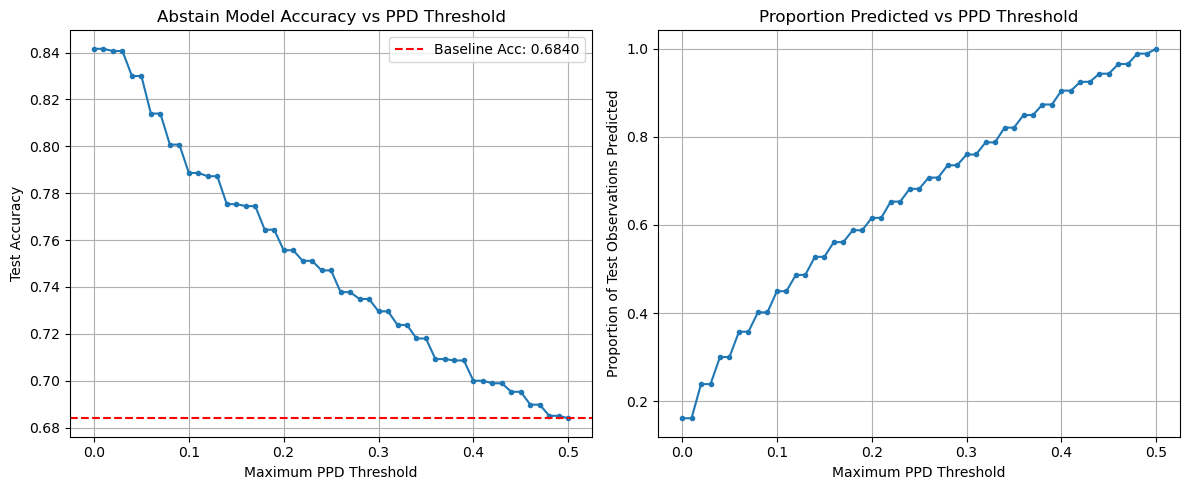

In [23]:
# your code here
# Calculate bagged predictions (average of all bootstrap predictions)
bagged_probs = np.mean(bootstrap_preds, axis=1)
bagged_preds = (bagged_probs > 0.5).astype(int)

# Calculate baseline accuracy for all predictions
baseline_accuracy = np.mean(bagged_preds == y_test.values)
print(f"Bagging model test accuracy (all observations): {baseline_accuracy:.4f}")

# Calculate PPD for each test observation
bootstrap_binary_preds = (bootstrap_preds > 0.5).astype(int)
majority_class = np.round(np.mean(bootstrap_binary_preds, axis=1))
minority_votes = np.zeros(len(y_test))

for i in range(len(y_test)):
    # Count votes for minority class
    if majority_class[i] == 1:
        minority_votes[i] = n_bootstraps - np.sum(bootstrap_binary_preds[i])
    else:
        minority_votes[i] = np.sum(bootstrap_binary_preds[i])

# Calculate PPD
ppd = minority_votes / n_bootstraps

# Create thresholds for PPD
ppd_thresholds = np.linspace(0, 0.5, 51)

# Calculate accuracy and proportion predicted for each threshold
accuracies, proportions_predicted = [], []

for threshold in ppd_thresholds:
    # Identify observations to keep (not abstain)
    keep_mask = ppd <= threshold

    # Caluclate accuracy on non-abstained observations
    if np.sum(keep_mask) > 0:
        accuracy = np.mean(bagged_preds[keep_mask] == y_test.values[keep_mask])
        accuracies.append(accuracy)
    else:
        accuracies.append(np.nan)

    # Calculate proportion of observations predicted
    proportion = np.mean(keep_mask)
    proportions_predicted.append(proportion)

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(ppd_thresholds, accuracies, marker='o', markersize=3)
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label=f'Baseline Acc: {baseline_accuracy:.4f}')
plt.xlabel('Maximum PPD Threshold')
plt.ylabel('Test Accuracy')
plt.title('Abstain Model Accuracy vs PPD Threshold')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ppd_thresholds, proportions_predicted, marker='o', markersize=3)
plt.xlabel('Maximum PPD Threshold')
plt.ylabel('Proportion of Test Observations Predicted')
plt.title('Proportion Predicted vs PPD Threshold')
plt.grid(True)

plt.tight_layout()
plt.show()



*The results indicate a clear inverse relationship between model accuracy and prediction coverage when implementing the abstain bagging approach. As the PPD threshold decreases (requiring greater model consensus), test accuracy improves dramatically from the baseline of 68.3% to approximately 85% at the most strict threshold, exemplifying that allowing the model to abstain on uncertain predictions substantially improves performance. However, this accuracy gain comes at a significant cost in prediction coverage, with only about 15% of test observations receiving predictions at the lowest PPD thresholds, creating a clear trade-off between accuracy and utility. The nearly monotonic decrease in accuracy as the PPD threshold increases confirms that bootstrap model disagreement serves as an effective uncertainty metric, enabling practitioners to balance prediction confidence against coverage requirements based on the specific costs of errors vs. abstentions in their application context. When the PPD threshold is 0.5 (rightmost point on the graphs), the model makes predictions for all observations but achieves teh same accuracy as the baseline model which is to be expected as this represents the case where no observations are abstained.*



<a id="part2"></a>

<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 2 [50 pts]: The Quick, Draw!  Kaggle competition

[Return to contents](#contents)


<a id="part2intro"></a>

## Problem Statement

[Return to contents](#contents)

Artificial neural networks (ANNs) are prone to overfitting, learning patterns specific to the training data that do not generalize to new data.

There are several methods to reduce ANN generalization error. 

One approach is to use an architecture just barely wide or deep enough to fit the data. The idea here is that smaller networks are less expressive and thus less likely to overfit the data.

However, it is difficult to know a priori the correct size of the ANN, and it is computationally costly to hunt for the correct size. Given this, other methodologies are used to prevent overfitting and improve ANNs' generalizability. These methodologies, like other techniques that combat overfitting, fall under the umbrella term of "regularization."



<a id="part2about"></a>

## The Quick, Draw! Dataset 

[Return to contents](#contents)


![](img/quickdrawpreview.jpg)



For this problem, we will be working with a modified version of the [The Quick, Draw! Dataset](https://github.com/googlecreativelab/quickdraw-dataset), which is a large database of 50 million drawings across 345 categories, collected from players of the game [Quick, Draw!](https://quickdraw.withgoogle.com/).

For this homework, we will simplify the problem by using only 120,000 images across 10 different classes for training (this includes the data you will use for validation) and a test set of 30,000 images.


<a id="part2data"></a>

## Downloading the Data Files

[Return to contents](#contents)


**The required `train.csv` and `test.csv` data files are available on [the "Data" tab of the CS1090B HW2 Kaggle Competition website](https://www.kaggle.com/t/f70f40cbdf44c3cfdb32a37dcb52ebe1). They are also included with this assignment in `data/quickdraw.zip`. (DO NOT USE DATA FROM ANY OTHER SOURCE!)**

Here's a brief description of the data files:

- `train.csv` is our training dataset and the `label` column contains our response class. The 784 other columns correspond to the pixel values of the 28x28 dimension image.  `train.csv` has 120,000 samples.

- `test.csv` file mirrors the structure of the `train.csv` file **without** the class label column. We have added another column `id`. `id` is a unique identifier for each sample in the test set. This ID is crucial for mapping your model's predictions back to the corresponding samples when submitting your results to Kaggle. `test.csv` has 30,000 samples. 

- Since the `test.csv` does not include the true labels, it is used exclusively for generating predictions that you'll submit to Kaggle for evaluation.  Your task is to predict the class labels for each sample in `test.csv` and submit these predictions in the required format.


Kaggle leaderboard scores are accuracy scores calculated by Kaggle when you upload your predictions on this test set.

- `sample_submission.csv` is the format that kaggle will accept. The uploaded `.csv` must contain 2 columns. The first column must be named `id` and needs to contain the test observation index numbers for each prediction, the second must be named `label` and needs to contain your class predictions (i.e. 'cat', 'dog' etc) for each corresponding test observation index location. 

<a id="part2kaggle"></a>

## CS1090B Kaggle Competition

[Return to contents](#contents)

**ACCESS AND JOIN THE COMPETITION**:

**You need to create an account on Kaggle and [join the competition via this link](https://www.kaggle.com/t/f70f40cbdf44c3cfdb32a37dcb52ebe1). This is a limited participation competition. Please DO NOT share this link.**

**For more information on the rules** governing this CS1090B Kaggle competition, please see below and also review [the modeling restrictions DOS and DON'TS outlined in question 2.3.2](#q2.3.2).

**IMPORTANT NOTES ABOUT SCORING**:

- The **public leaderboard** on Kaggle displays your performance on only 30% of the test set.


- After the competition is complete, the **private leaderboard** will show your performance on the remaining 70% of the test set.

- Question 2.3.6 is worth 30 points (the entire notebook is scored out of 100). Points for this questions will be awarded based on the **private leaderboard** accuracy score using the formula:
$$
\text{relu}(\text{max}(30, 4.3\times 100\times(\text{score} - 0.78)))
$$

**🏆 Grand Prize(s):** The **Top-2** students on the private leaderboard will win an invitation to dinner with Pavlos and some of the CS1090B teaching staff. This refers to the top 2 individuals on the board. The invitation will be extended to 3 students if the restriction to 2 would otherwise divide a group (e.g., 1 single submissions at the top followed by a group of 2).

**ADDITIONAL COMPETITION RULES:**

- Multiple Kaggle submissions are permitted (with a maximum of 5 submissions per team per-day), **just note that you will need to choose, on Kaggle, the ONE single submission to use for final scoring prior to the final HW2 submission deadline**, and **your submitted notebook MUST contain the matching code and model that generated your ONE chosen submission.**


- **To repeat this point, the version of your final HW2 notebook submitted on Canvas MUST contain the same code and exact same model used to generate your ONE chosen Kaggle submission.** (TFs may rerun your notebook code to ensure comparable final leaderboard results.)


- **Please do not manually label your submissions.** In other words, the labels should only be the outcome of your model.


- **No external data are allowed, you MUST USE ONLY the training and test data downloaded via the "Data" tab of [the CS1090B competition page linked above](#part2data).**


- **Do not** create multiple accounts on Kaggle.


<div class='exercise-r'>

**2.1**  **Download and visualize the data**

- Download the train and test data from [the competition page](#part2data).
- We will utilize `test.csv` in question 2.3.5 only. 
- Load the data and use the matplotlib function `imshow` to display 25 samples  from each of the 10 classes from the training set. Total of 250 samples, 10 rows of 25 images each.
- You are responsible for any preprocessing you deem necessary to help in your prediction task.

</div>

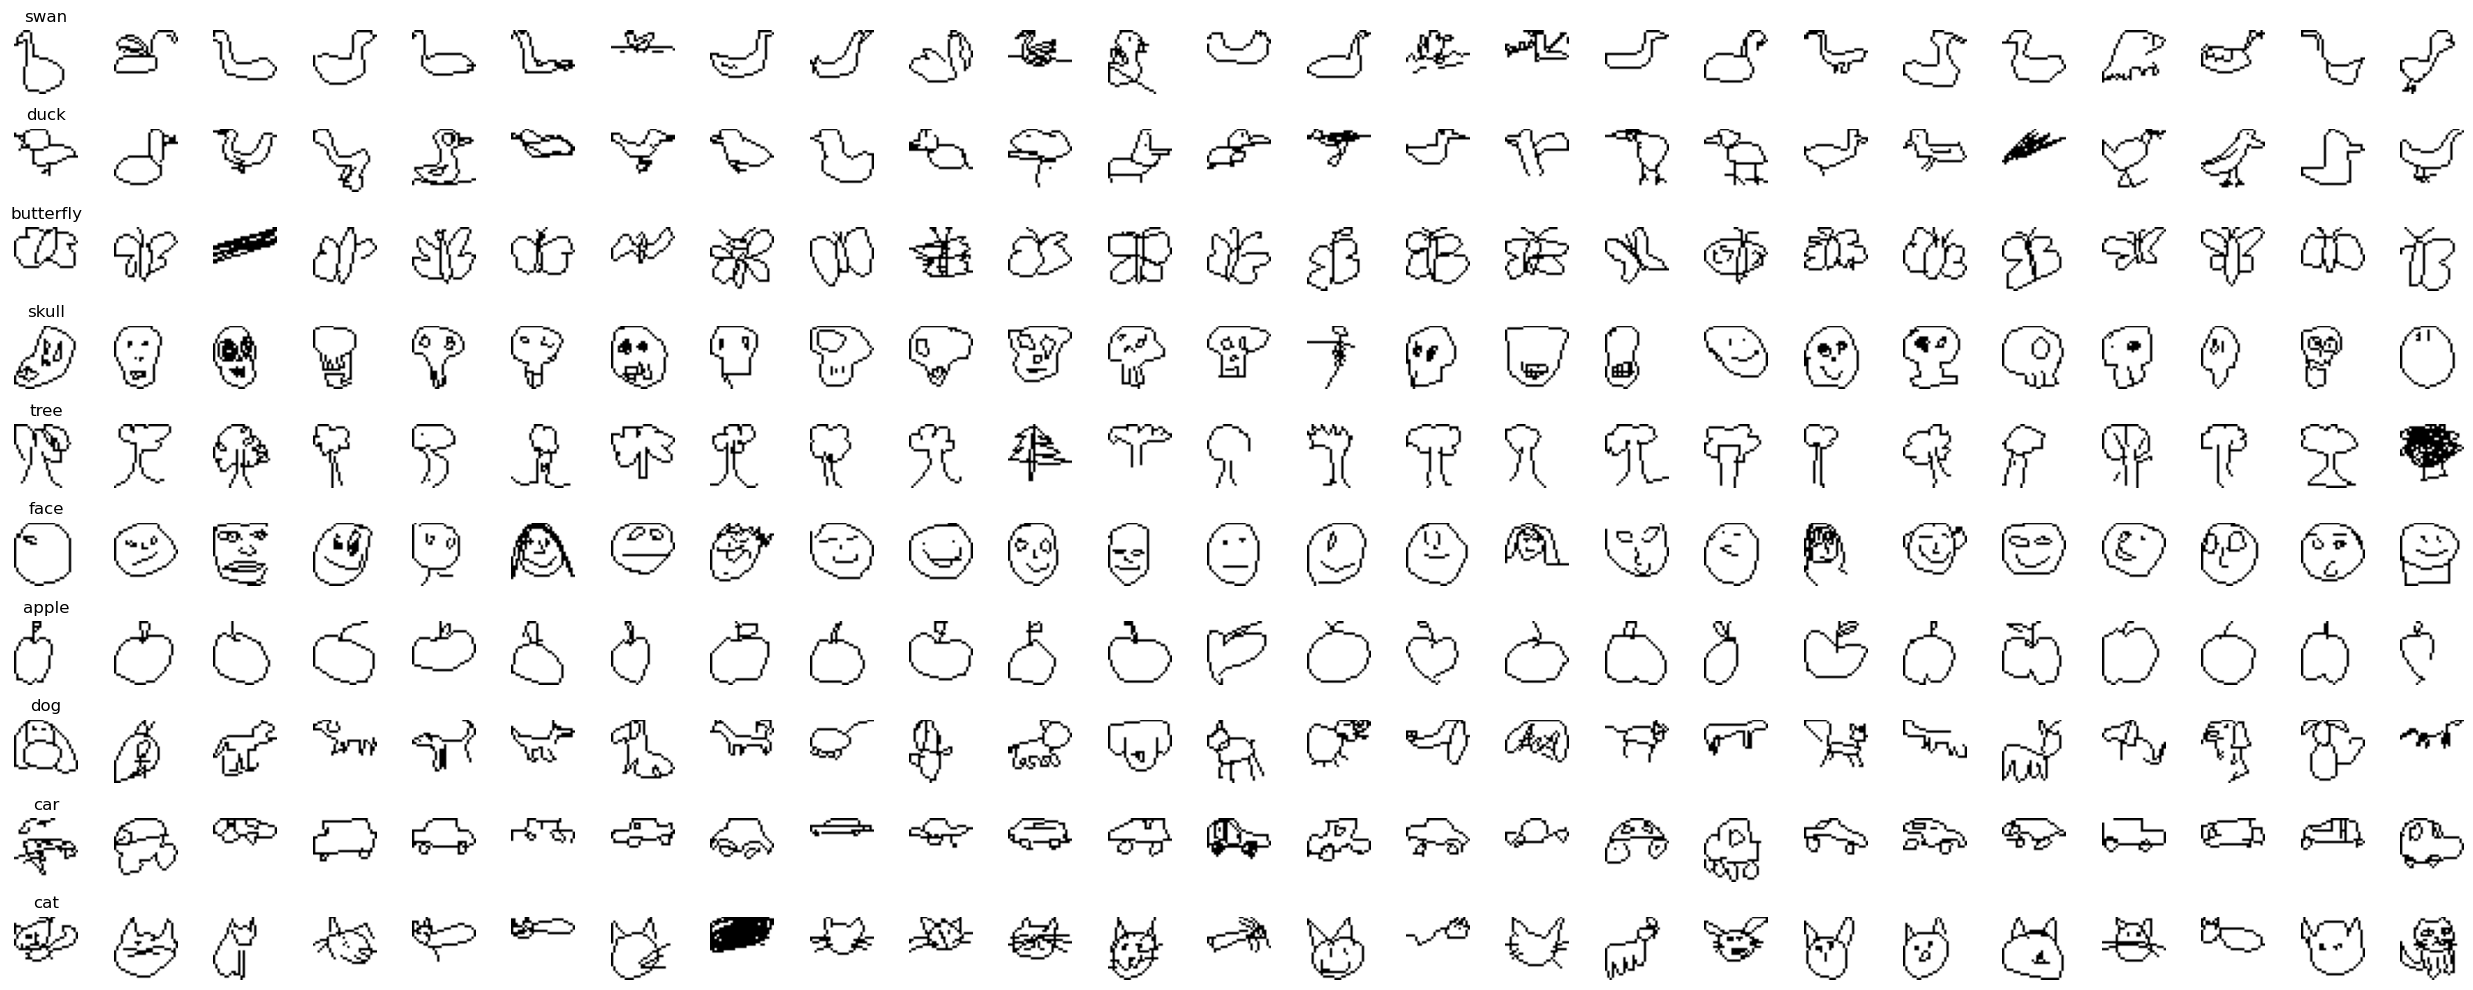

In [10]:
# your code here
# Load data
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

# Check unique classes
unique_classes = train_df['label'].unique()

# Visualize 25 samples from each of the 10 classes
plt.figure(figsize=(25, 10))
for i, class_name in enumerate(unique_classes):
    # Get 25 samples from the current class
    class_samples = train_df[train_df['label'] == class_name].iloc[:25]
    
    for j in range(25):
        # Create subplot in a 10×25 grid
        plt.subplot(10, 25, i*25 + j + 1)
        
        # Reshape the 784 pixels into a 28×28 image
        img = class_samples.iloc[j, :-1].values.astype(float).reshape(28, 28)
        
        # Display the image
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        
        # Add class label to the first image in each row
        if j == 0:
            plt.title(class_name, fontsize=12)

plt.tight_layout()
plt.savefig('q2_1.png')
plt.show()

In [11]:
# your code here
# Convert pixel values to floats and normalize
X_train = train_df.iloc[:, :-1].values.astype('float32') / 255.0
X_test = test_df.iloc[:, 1:].values.astype('float32') / 255.0

# Encode labels as integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class mapping:", class_mapping)

# Create validation set
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Print preprocessing summary
print(f"Percentage of zero values in training data: {np.mean(X_train == 0) * 100:.2f}%")
print(f"Training set shape: {X_train_final.shape}")
print(f"Validation set shape: {X_val.shape}")

Class mapping: {'apple': 0, 'butterfly': 1, 'car': 2, 'cat': 3, 'dog': 4, 'duck': 5, 'face': 6, 'skull': 7, 'swan': 8, 'tree': 9}
Percentage of zero values in training data: 13.78%
Training set shape: (96000, 784)
Validation set shape: (24000, 784)


<div class='exercise-r'>

**2.2**  **Overfit an ANN** 

Build and fit a fully-connected network (FCN) with the architecture given below using `tensorflow.keras` and assign it to a variable called `model_overfit`:

- Number of hidden layers: 3
- Nodes per hidden layer: 10000, 10000, 10000
- Activation function: ReLU 
- Loss function: sparse_categorical_crossentropy
- Output unit: Softmax 
- Optimizer: adam (use the defaults; no other tuning)
- Epochs: 20
- Batch size: 128
- Validation size: 0.2

    
    
This ANN, when trained on the dataset, will overfit to the training set. Plot the training accuracy and validation accuracy (the x-axis should represent the number of epochs, and the y-axis should represent the accuracy). Explain how you can tell the model is overfitting. 

</div>

In [14]:
# your code here
# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

# Build overfitting model
model_overfit = Sequential([
    # Input: 784 features (28x28 flattened)
    Dense(10000, activation='relu', input_shape=(784,), 
          kernel_initializer='he_normal'),
    Dense(10000, activation='relu', kernel_initializer='he_normal'),
    Dense(10000, activation='relu', kernel_initializer='he_normal'),
    Dense(10, activation='softmax', kernel_initializer='glorot_uniform')
])

# Compile with low learning rate
model_overfit.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model_overfit.summary()

/Users/nico/miniconda3/envs/ac209b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 10000)          │     7,850,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10000)          │   100,010,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10000)          │   100,010,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │       100,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,970,010 (793.34 MB)

 Trainable params: 207,970,010 (793.34 MB)

 Non-trainable params: 0 (0.00 B)

Training new model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 10000)          │     7,850,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10000)          │   100,010,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10000)          │   100,010,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │       100,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,970,010 (793.34 MB)

 Trainable params: 207,970,010 (793.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-03-05 22:54:29.019018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-03-05 22:54:29.021720: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.2617 - loss: 10.5862

2025-03-05 22:56:20.324323: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


750/750 ━━━━━━━━━━━━━━━━━━━━ 113s 150ms/step - accuracy: 0.2620 - loss: 10.5803 - val_accuracy: 0.7406 - val_loss: 0.7878
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 119s 159ms/step - accuracy: 0.7429 - loss: 0.7704 - val_accuracy: 0.7694 - val_loss: 0.6976
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 133s 177ms/step - accuracy: 0.8023 - loss: 0.5950 - val_accuracy: 0.7835 - val_loss: 0.6561
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 127s 170ms/step - accuracy: 0.8482 - loss: 0.4585 - val_accuracy: 0.7828 - val_loss: 0.6985
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 119s 159ms/step - accuracy: 0.8834 - loss: 0.3537 - val_accuracy: 0.7812 - val_loss: 0.7574
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 119s 159ms/step - accuracy: 0.9018 - loss: 0.2900 - val_accuracy: 0.7756 - val_loss: 0.8188
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 124s 165ms/step - accuracy: 0.9253 - loss: 0.2188 - val_accuracy: 0.7310 - val_loss: 1.1212
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 128s 171ms/step - accuracy: 0.9432 - loss: 0.1

Model saved to model_overfit.h5
History saved to history_overfit.json


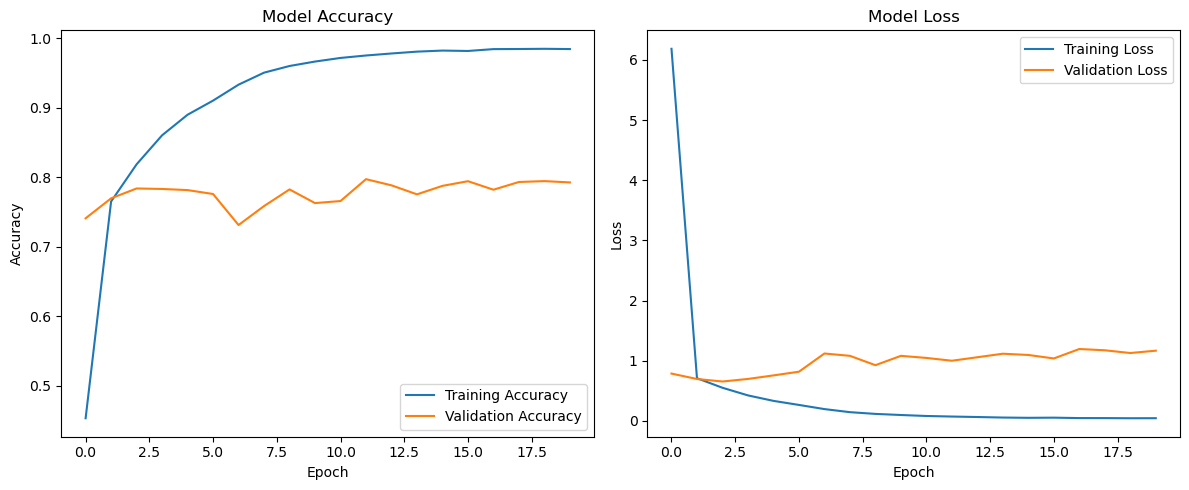

In [15]:
# Check if model and history already exist
model_path = 'model_overfit.h5'
history_path = 'history_overfit.json'

if os.path.exists(model_path) and os.path.exists(history_path):
    print("Loading existing model and history...")
    model_overfit = load_model(model_path)
    
    with open(history_path, 'r') as f:
        history_dict = json.load(f)
    
    # Create a class with history attribute to mimic model.fit() return
    class HistoryObject:
        pass
    
    history_overfit = HistoryObject()
    history_overfit.history = history_dict
    
    print("Model and history loaded successfully!")
else:
    print("Training new model...")
    # Build the intentional overfitting model
    model_overfit = Sequential([
        # Input is 784 features (28x28 flattened)
        Dense(10000, activation='relu', input_shape=(784,), 
              kernel_initializer='he_normal'),
        Dense(10000, activation='relu', kernel_initializer='he_normal'),
        Dense(10000, activation='relu', kernel_initializer='he_normal'),
        Dense(10, activation='softmax', kernel_initializer='glorot_uniform')
    ])

    # Compile with a slightly lower learning rate
    model_overfit.compile(
        optimizer=Adam(learning_rate=0.0001),  # Lower learning rate helps convergence
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Display model summary
    model_overfit.summary()

    # Train the model
    history_overfit = model_overfit.fit(
        X_train_final, y_train_final,
        epochs=20,
        batch_size=128,
        validation_data=(X_val, y_val),
        verbose=1
    )
    
    # Save model and history
    model_overfit.save(model_path)
    
    with open(history_path, 'w') as f:
        json.dump(history_overfit.history, f)
    
    print(f"Model saved to {model_path}")
    print(f"History saved to {history_path}")

# Plot learning curves to demonstrate overfitting
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_overfit.history['accuracy'], label='Training Accuracy')
plt.plot(history_overfit.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_overfit.history['loss'], label='Training Loss')
plt.plot(history_overfit.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('learning_curves.png')
plt.show()

*You can clearly see that the model is overfitting due to the following:*

1. Growing gap between training and validation accuracy: the training accuracy increases continuously, reaching approximately 98%, while the validation accuracy plateaus around 78-80%. This gap is huge, approximately 20%, between training and validation accuracy, suggesting the model memorized the training data very well causing it to not perform well on unseen data in the validation set.
1. Diverging loss curves: the training loss continues decreasing throughout training towards 0 while the validation loss initially decreases but then increases throughout the training process. This is a definitive sign of overfitting.

*In summary, the extremely high training accuracy coupled with plateaued validation performance alongside the validation loss curve increasing while the training loss curve decreases point towards overfitting.*



<div class='exercise-r'>
<a id="q2.3.1"></a>

**2.3.1** **Enhancing Feature Extraction with Fourier Transforms**

Neural networks can learn useful representations of their inputs while simultaneously solving tasks like classification. This process, called **representation learning**, can be seen as a form of feature extraction. However, incorporating **explicit feature transformations** can still improve performance. One such transformation is the **Fourier Transform (FT)**, which decomposes an image into its frequency components. This alternative representation can highlight patterns that may not be easily captured in the pixel space. The **Fast Fourier Transform (FFT)** is an efficient algorithm for computing the FT.

Your task:
- **Implement a custom Keras layer** that applies the **FFT** to its input.
- **Incorporate this layer** into a neural network architecture for classifying the "Quick, Draw!" dataset.
- **Describe your approach**: Explain where and how you added the FFT layer, your reasoning behind it, and whether it improved performance compared to the previous model.

**Hints**
- Experiment with the [Functional Keras API](https://www.tensorflow.org/guide/keras/functional_api) and the [Concatenate layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate).
- You may find the following documentation helpful:
  - [TensorFlow FFT function](https://www.tensorflow.org/api_docs/python/tf/signal/fft2d)
  - [Building Custom Keras Layers](https://www.tensorflow.org/guide/keras/custom_layers_and_models)

⚠️ **Note:** This question is worth 5 points out of the 100 possible points in the notebook, so allocate your time accordingly.
</div>

In [16]:
# your code here
from tensorflow.keras.layers import Layer

class FFTLayer(Layer):    
    def __init__(self, **kwargs):
        super(FFTLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        super(FFTLayer, self).build(input_shape)
        
    def call(self, inputs):
        # Reshape flattened input to square images
        batch_size = tf.shape(inputs)[0]
        img_dim = int(np.sqrt(inputs.shape[1]))
        x_reshaped = tf.reshape(inputs, [batch_size, img_dim, img_dim])
        
        # Cast to complex64 for FFT
        x_complex = tf.cast(x_reshaped, tf.complex64)
        
        # Apply 2D FFT
        fft_output = tf.signal.fft2d(x_complex)
        
        # Extract magnitude of FFT
        fft_mag = tf.abs(fft_output)
        
        # Apply log transformation to compress range
        fft_log = tf.math.log(fft_mag + 1)
        
        # Normalize
        fft_normalized = fft_log / tf.reduce_max(fft_log, axis=[1, 2], keepdims=True)
        
        # Flatten output
        fft_flat = tf.reshape(fft_normalized, [batch_size, img_dim * img_dim])
        
        return fft_flat
        
    def compute_output_shape(self, input_shape):
        return input_shape


In [17]:
# your code here
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model

# Define the input
inputs = Input(shape=(784,))

# Apply FFT transformation
fft_features = FFTLayer()(inputs)

# Process original pixel data
original_branch = Dense(512, activation='relu')(inputs)
original_branch = Dropout(0.3)(original_branch)
original_branch = Dense(256, activation='relu')(original_branch)

# Process FFT features
fft_branch = Dense(512, activation='relu')(fft_features)
fft_branch = Dropout(0.3)(fft_branch)
fft_branch = Dense(256, activation='relu')(fft_branch)

# Concatenate both branches
combined = Concatenate()([original_branch, fft_branch])

# Add final hidden layers
x = Dense(256, activation='relu')(combined)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)

# Output layer
outputs = Dense(10, activation='softmax')(x)

# Create and compile the model
fft_model = Model(inputs=inputs, outputs=outputs)
fft_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
fft_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_3 (Cast)       │ (None, 784)       │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_4 (Cast)       │ (None, 784)       │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fft_layer           │ (None, 784)       │          0 │ cast_3[0][0]      │
│ (FFTLayer)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 512)       │    401,920 │ cast_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 512)       │    401,920 │ fft_layer[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ dense_13[0][0],   │
│ (Concatenate)       │                   │            │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │    131,328 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 10)        │      1,290 │ dense_17[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,232,010 (4.70 MB)

 Trainable params: 1,232,010 (4.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


2025-03-05 23:48:57.138882: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.3608 - loss: 1.7442 - val_accuracy: 0.6205 - val_loss: 1.0634
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.6099 - loss: 1.1452 - val_accuracy: 0.6856 - val_loss: 0.9159
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6434 - loss: 1.0495 - val_accuracy: 0.7188 - val_loss: 0.8381
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6715 - loss: 0.9798 - val_accuracy: 0.7375 - val_loss: 0.7953
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6814 - loss: 0.9459 - val_accuracy: 0.7403 - val_loss: 0.7854
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6972 - loss: 0.9051 - val_accuracy: 0.7469 - val_loss: 0.7593
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7006 - loss: 0.8871 - val_accuracy: 0.7508 - val_loss: 0.7449
Epoch 8/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.7123 - loss: 0.8544 - val_accurac

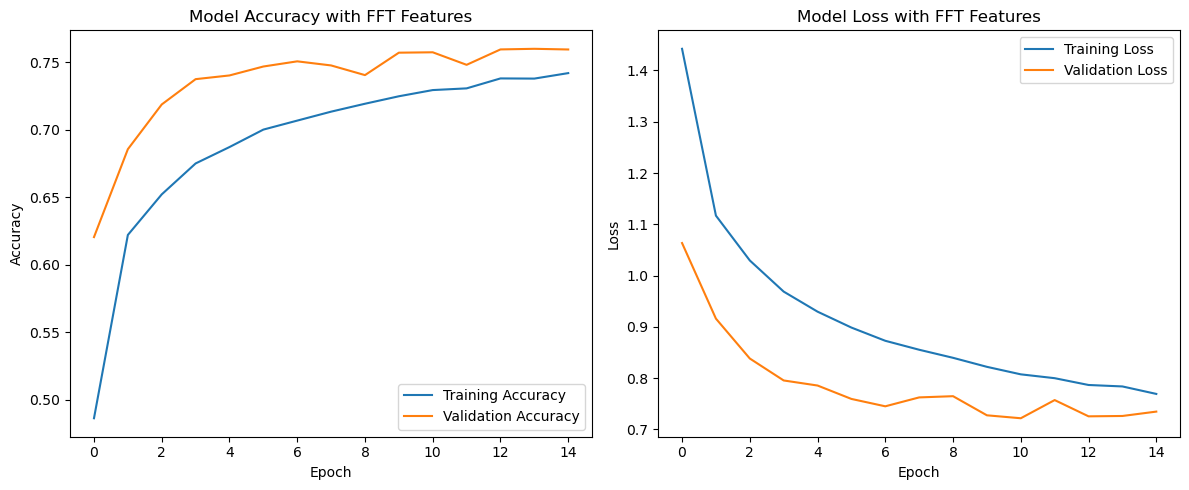

In [18]:
# your code here
# Train the model
history_fft = fft_model.fit(
    X_train_final, y_train_final,
    epochs=15,
    batch_size=128,
    validation_data=(X_val, y_val),
    verbose=1
)

# Plot learning curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_fft.history['accuracy'], label='Training Accuracy')
plt.plot(history_fft.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy with FFT Features')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fft.history['loss'], label='Training Loss')
plt.plot(history_fft.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with FFT Features')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

*I created a custom layer that transforms input data from pixel space to frequency space using a fast Fourier transform. The layer effectively reshapes the flattened input (1, 784) into (28, 28) images. It applies FFT, extracting the magnitude, then applies logarithmic scaling to compress the dynamic range, followed by a normalization step. Lastly, it flattens the output to maintain the same shape as the input. I used a two-branch architecture with Keras Functional API. One branch's purpose is to process the original pixel data and the other's purpose is to process the transformed data.Both branches have similar structures with dense layers and dropout. The branches are concatenated and processed through additional layers before final classification. The FFT provides information to the raw pixel values by revealing frequency patterns, offering potentially useful insights. These patterns can help identify features like strokes, curves, or other repetitive elements in the drawings which could be useful. For example, car drawings may have more horizontal components while trees may have more vertical patterns, and these differences would be more recognizable in the frequency domain than the pixel value one. By leveraging both the pixel and frequency domains, the model can learn more effectively. And the resulting plots definitely corroborate this theory as validation accuracy increases along with training accuracy and validation loss decreases along with training loss and the differences between the accuracies is not nearly as large as it was in the overfitted model example from Q2.2.*



<div class='exercise-r'>
<a id="q2.3.2"></a>

**2.3.2**  **Kaggle Competition**

Create an ANN and use it to [compete on Kaggle](#part2kaggle).

<a id="q2.3.2"></a>
    
**DON'TS**

- **No CNNs, transfer learning, RNNs, ensembles, and no ensembles with folds.**

- **DO NOT manually label your submissions.** In other words, the labels should only be the outcome of your model.

- **DO NOT use any external data.** Please use ONLY the specific dataset provided to you (via the CS1090B [data link above](#part2data)) for training your model and for generating your test predictions.

**DOS**

 - **YOU CAN change the** number of epochs (max 2000), batch size, optimizer, and of course, add elements that can help to regularize your model.
 - **YOU CAN** do data augmentation using the provided training data.
 - **YOU CAN** make use of your custom Fourier Transform layer from the previous question. 

**IMPORTANT: YOU MUST** ensure that the version of the code and model in your final submitted notebook is the **EXACT SAME** code and model used to generate your Kaggle submission. TFs may run your submitted model to ensure comparable results. **Other Kaggle competition rules and scoring details [are listed here](#part2kaggle).**

</div>

In [ ]:
# your code here


<div class='exercise-r'>

**2.3.3**  Plot your model's training accuracy and validation accuracy as a function of epochs.




</div>

In [ ]:
# your code here


<div class='exercise-r'>

**2.3.4**  In a few sentences, describe the various approaches you have taken to improve the performance of your regularized model in 2.3.2 as well as any observations you might have regarding your training and Kaggle results.


</div>

*Your answer here*



<div class='exercise-r'>

**2.3.5**  Generate your test-set class predictions using your regularized model. Save those predictions to a `.csv` formatted file. Submit that `.csv` file [to the CS1090B Kaggle Competition](#part2kaggle) for leaderboard scoring. 

**IMPORTANT:** For Kaggle to accept and score your submitted `.csv` file, it MUST contain 2 columns. The first column must be named `"id"` and needs to contain the test observation index numbers corresponding to each of your 30,000 predictions, the second column must be named `"label"` and needs to contain your class predictions (i.e. `cat` or `dog` etc.) for each corresponding test observation index location. A sample submission file is provided on [Kaggle](https://www.kaggle.com/competitions/cs-109-b-hw-2-contest-2025/data?select=sample_submission.csv)
</div>

In [ ]:
# your code here
...

<div class='exercise-r'>

**2.3.6**  **Specify your Kaggle name that you have used on the leaderboard**. We CANNOT give you credit without this.

</div>

**YOUR KAGGLE LEADERBOARD NAME:**

*Your answer here*



<!-- BEGIN QUESTION -->

<div class='exercise-r'><b>2.4 Wrap-up</b></div>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

In [ ]:
hours_spent_on_hw = 15

*Your answer here*



In [ ]:
grader.check("q2.4")

In [ ]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

**This concludes HW2. Thank you!**